# Schmidt et al. 2016 Proteome data set

© 2021 Tom Röschinger
. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

***

In this notebook we will explore a huge data set in which the abundance (in terms absolute copy number) of more than 2000 proteins of *E. Coli* was measured in 22 different growth conditions. You can find the paper [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4888949/). In this notebook, we will use the tables from the supplementary information that you can find [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4888949/bin/NIHMS65833-supplement-Supplementary_tables.xlsx). This notebook will give an example on how to work with real world data, what kind of manipulations one has to do and how one can extract usefull and possibly even new information from datasets that are already around.

In [14]:
using Pandas, CairoMakie, Jedi, DataFrames, LinearAlgebra, Statistics
CairoMakie.activate!
Jedi.styles.default_makie!()

# Import data. Change path if necessary
df = DataFrames.DataFrame(Pandas.read_excel("../../../data/heinemann_data.xlsx", sheet_name="Table S6", header=[2]))
first(df, 5)

,Uniprot Accession,Description
,String,String
1,P0A8T7,DNA-directed RNA polymerase subunit beta' OS=Escherichia coli (strain K12) GN=rpoC PE=1 SV=1
2,P0A8V2,DNA-directed RNA polymerase subunit beta OS=Escherichia coli (strain K12) GN=rpoB PE=1 SV=1
3,P36683,Aconitate hydratase 2 OS=Escherichia coli (strain K12) GN=acnB PE=1 SV=3
4,P15254,Phosphoribosylformylglycinamidine synthase OS=Escherichia coli (strain K12) GN=purL PE=1 SV=3
5,P09831,Glutamate synthase [NADPH] large chain OS=Escherichia coli (strain K12) GN=gltB PE=1 SV=3


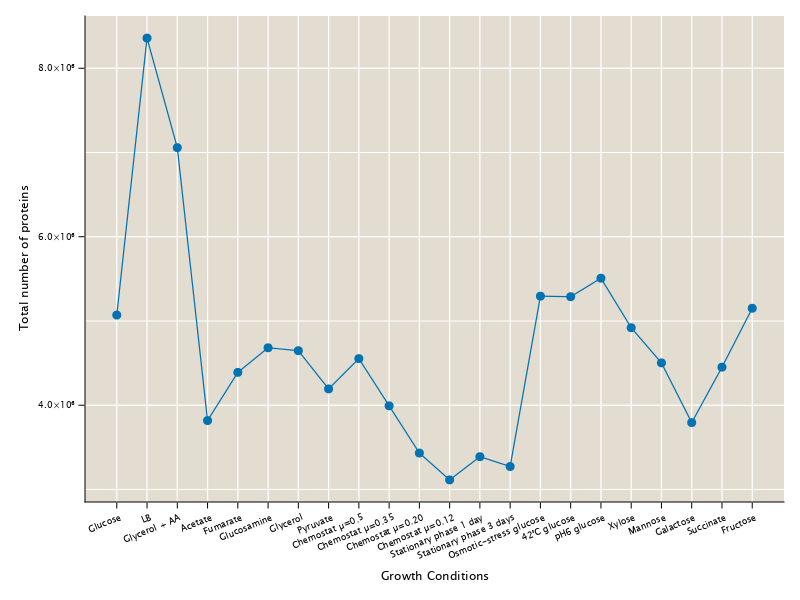

In [19]:
growth_conditions = ["Glucose",
 "LB",
 "Glycerol + AA",
 "Acetate",
 "Fumarate",
 "Glucosamine",
 "Glycerol",
 "Pyruvate",
 "Chemostat µ=0.5",
 "Chemostat µ=0.35",
 "Chemostat µ=0.20",
 "Chemostat µ=0.12",
 "Stationary phase 1 day",
 "Stationary phase 3 days",
 "Osmotic-stress glucose",
 "42°C glucose",
 "pH6 glucose",
 "Xylose",
 "Mannose",
 "Galactose ",
 "Succinate",
 "Fructose"]

 # Compute mean copy number per growth condition
tot_prot = [sum(df[.~isnan.(df[!, cond]), cond]) for cond in growth_conditions]

# Plot total protein number
fig = Figure(resolution = (800, 600))
ax1 = Axis(
    fig[1, 1], 
    ylabel="Total number of proteins",
    xlabel="Growth Conditions"
)
lines!(ax1, 1:22, tot_prot)
scatter!(ax1, 1:22, tot_prot, )

ax1.xticklabelrotation = pi/8
ax1.xticks = 1:length(growth_conditions)
ax1.xtickformat = x -> growth_conditions
ax1.xminorgridwidth = 0

#CairoMakie.save("figures/heinemann_total_protein.pdf", fig)
fig

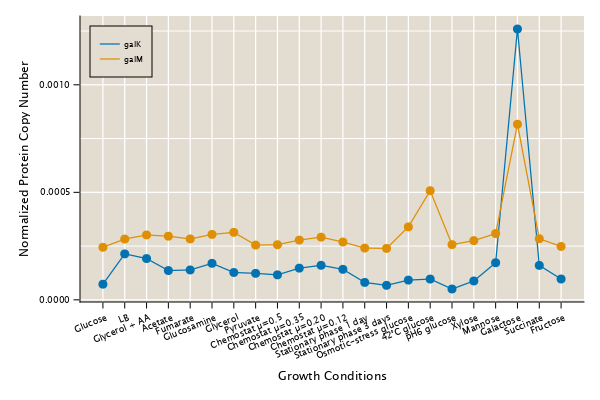

In [20]:
## Function to plot protein number per gene
"""
    copy_number_plot(genes, normalized=False)  

Plot the copy number of a list of genes in all 
growth conditions.
"""
function copy_number_plot(genes, normalized=false)

    fig = Figure(resolution = (600, 400))
    ax1 = Axis(
        fig[1, 1], 
        ylabel="Total number of proteins",
        xlabel="Growth Conditions"
    )

    # Iterate through genes
    for gene in genes
        # Extract row for gene
        if ~(gene in df[!, "Gene"])
            throw(ArgumentError("Gene $gene is not in the data set."))
        end
        row = df[df[!, "Gene"] .== gene, growth_conditions] |> Matrix |> vec
        mask = map(x -> ~isnan(x), row)

        # Normalize
        if normalized
            row[mask] .= row[mask] ./ tot_prot[mask]
        end
        
        # Plot and make label
        lines!(ax1, collect(1:22)[mask], row[mask], label=gene)
        scatter!(ax1, collect(1:22)[mask], row[mask])
    end


    # Annotate plot
    if normalized
        ax1.ylabel = "Normalized Protein Copy Number"
    else
        ax1.ylabel = "Protein Copy Number"
    end
    
    ax1.xticklabelrotation = pi/8
    ax1.xticks = 1:length(growth_conditions)
    ax1.xtickformat = x -> growth_conditions
    ax1.xminorgridwidth = 0
    axislegend(ax1, position= :lt)

    return fig
end

fig = copy_number_plot(["galK", "galM"], true)
fig


In [23]:
## Function to plot protein number per gene
"""
    copy_number_plot(genes, normalized=False)  

Plot the copy number of a list of genes in all 
growth conditions.
"""
function copy_number_plot(genes, normalized=false)

    fig = Figure(resolution = (800, 530))
    ax1 = Axis(
        fig[1, 1], 
        ylabel="Total number of proteins",
        xlabel="Growth Conditions"
    )

    # Iterate through genes
    for gene in genes
        # Extract row for gene
        if ~(gene in df[!, "Gene"])
            throw(ArgumentError("Gene $gene is not in the data set."))
        end
        row = df[df[!, "Gene"] .== gene, growth_conditions] |> Matrix |> vec
        mask = map(x -> ~isnan(x), row)

        # Normalize
        if normalized
            row[mask] .= row[mask] ./ tot_prot[mask]
        end
        
        # Plot and make label
        lines!(ax1, collect(1:22)[mask], row[mask], label=gene)
        scatter!(ax1, collect(1:22)[mask], row[mask])
    end


    # Annotate plot
    if normalized
        ax1.ylabel = "Normalized Protein Copy Number"
    else
        ax1.ylabel = "Protein Copy Number"
    end
    
    ax1.xticklabelrotation = pi/8
    ax1.xticks = 1:length(growth_conditions)
    ax1.xtickformat = x -> growth_conditions
    ax1.xminorgridwidth = 0
    axislegend(ax1, position= :lt)

    return fig
end

fig = copy_number_plot(["galK", "galM"], true)
fig

##
function compute_variation(df)
    gene_vals = Matrix(df[!, growth_conditions])
    replace!(gene_vals, NaN=>0)
    return var(gene_vals ./ vec(tot_prot)', dims=2) ./ mean(gene_vals ./ vec(tot_prot)', dims=2)
end

df.variation = vec(compute_variation(df))
sort!(df, :variation, rev=true)

,Uniprot Accession,Description
,String,String
1,P0AES9,Chaperone-like protein hdeA OS=Escherichia coli (strain K12) GN=hdeA PE=1 SV=1
2,P0A9G6,Isocitrate lyase OS=Escherichia coli (strain K12) GN=aceA PE=1 SV=1
3,P0ABT2,DNA protection during starvation protein OS=Escherichia coli (strain K12) GN=dps PE=1 SV=2
4,P0ADB7,Entericidin B OS=Escherichia coli (strain K12) GN=ecnB PE=3 SV=1
5,P0AAX6,Uncharacterized protein McbA OS=Escherichia coli (strain K12) GN=mcbA PE=2 SV=2
6,P0A853,Tryptophanase OS=Escherichia coli (strain K12) GN=tnaA PE=1 SV=1
7,P0AEE5,D-galactose-binding periplasmic protein OS=Escherichia coli (strain K12) GN=mglB PE=1 SV=1
8,P00944,Xylose isomerase OS=Escherichia coli (strain K12) GN=xylA PE=3 SV=1
9,P37188,Galactitol-specific phosphotransferase enzyme IIB component OS=Escherichia coli (strain K12) GN=gatB PE=1 SV=2


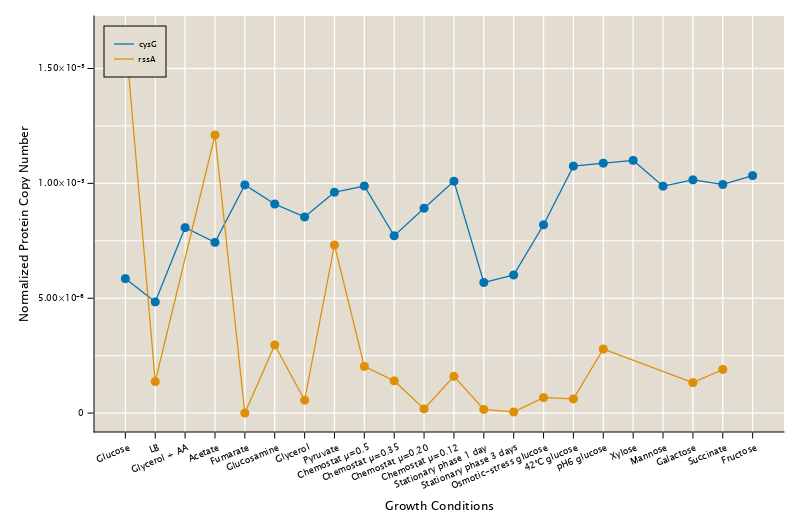

In [24]:
##
ref_genes = [
    "cysG",
    "hcaT",
    "idnT",
    "rssA"
]

fig = copy_number_plot(
    filter(x -> x in df.Gene, ref_genes), true
    )
fig